# **ESPIDAM: Getting Started with DQN**
***Authors: Bram Silue, Prof. dr. Pieter Libin, Prof. dr. Niel Hens.***

### **How to Run**
If you're having trouble running this code on your local machine, please open and run this notebook in Colab:

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/plibin/espidam-25/blob/main/deep-rl/1_dqn.ipynb)

We define some helper code that allows this notebook to run in both local environments and Google Colab:

In [ ]:
def is_running_in_colab() -> bool:
    """
    Returns if the code is running inside Google Colab.

    """
    try:
        import google.colab
        return True
    except ImportError:
        return False

### **Introduction**
Reinforcement Learning (RL) is a type of machine learning where an agent learns to make decisions by performing actions in an environment to maximize their cumulative reward. The **Deep Q-Network (DQN)** is a powerful learning RL algorithm that combines Q-learning with deep neural networks, enabling agents to learn effective policies in complex environments.

In this notebook, we will explore how to implement a DQN agent and train it to navigate the [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) environment from the OpenAI Gym. In the Lunar Lander simulation, the goal is to safely land a spacecraft between two flags on the lunar surface by controlling its thrusters. 

Here are some technical details about the Lunar Lander environment:
- The state is an 8-dimensional vector, composed of: 
    - The coordinates of the spacecraft in x & y, 
    - The linear velocities in x & y of the spacecraft,
    - The angle of the spacecraft,
    - The angular velocity of the spacecraft,
    - Two booleans that represent whether each leg is in contact with the ground or not.
- The action space is composed of four discrete actions:
    - Do nothing,
    - Fire bottom thruster,
    - Fire left thruster,
    - Fire right thruster.


### **Dependencies**
First, make sure to install miniconda and the necessary libraries as specified in [`README.md`](README.md). After that, we import the necessary libraries and dependencies as follows:

In [ ]:
# Environment.
print("Installing and importing libraries ...")
if is_running_in_colab():
    import subprocess
    subprocess.run(["pip", "install", "swig"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    subprocess.run(["pip", "install", "gymnasium"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    subprocess.run(["pip", "install", 'gymnasium[box2d]'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

import gymnasium as gym

# Machine learning.
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Plotting.
import matplotlib.pyplot as plt
from IPython import display
if is_running_in_colab():
    subprocess.run(["pip", "install", "renderlab"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    import renderlab

# Other tools.
import csv
import math
import random
from collections import deque, namedtuple
from scipy.signal import savgol_filter

# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

### **Reproducibility**
We make sure to define the *trajectory seed*. The trajectory seed refers to the random seed used to generate the sequence of actions and states experienced by an agent. Trajectory seeds are crucial for reproducibility because they ensure that the same sequence of experiences is produced across different runs, enabling researchers to replicate experiments and compare results accurately.

In [16]:
SEED = 42  # choose any seed you like.
if SEED:
    random.seed(SEED)        # we set the random seed of Python's random number generator.
    torch.manual_seed(SEED)  # we set the random seed of PyTorch's random number generator.

### **Helper Functions**
We define some helper functions that will make the code easier to read and understand later on.

In [17]:
# Helper object for environment transitions.
Transition = namedtuple('Transition', ('state',
                                       'action',
                                       'next_state',
                                       'reward'))

# Helper function for plotting.
def plot_performance(cumulative_rewards: list[float],
                     show_result: bool = False,
                     window_length: int = 25,
                     polyorder: int = 3) -> None:
    """
    Plots the learning curve, i.e., performance during training.

    Arguments
    ---------
    cumulative_rewards :  The list of cumulative rewards from episodes.
    show_result        :  Flag to either show the final result or the ongoing training plot.

    """
    # Create a new figure.
    plt.figure(1)

    # Convert the reward list to a tensor.
    rewards_t = torch.tensor(cumulative_rewards, dtype=torch.float)

    # Configure plot title based on whether or not we are still training.
    if show_result:
        plt.title('Result')
    else:
        plt.title('Training...')

    # Plot cumulative rewards.
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.plot(rewards_t.numpy(), label='Cumulative Reward', alpha=0.25)

    # Apply Savitzky-Golay filter to smooth the curve.
    # Smoothing is useful because it helps in identifying trends and patterns
    # that might be obscured by noise and fluctuations in the raw results.
    # (https://en.wikipedia.org/wiki/Savitzky–Golay_filter)
    if len(rewards_t) >= window_length:
        smoothed_rewards = savgol_filter(rewards_t.numpy(),
                                         window_length=window_length,
                                         polyorder=polyorder)
        plt.plot(smoothed_rewards, label='Smoothed Cumulative Reward', linewidth=2, color='orange')

    plt.legend()
    plt.pause(0.001)  # pause briefly to update plots.

    # Display the plot in the notebook.
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())
        plt.ioff()
        plt.show()

# Helper function for calculating epsilon.
def calculate_epsilon(EPS_START: float,
                      EPS_END: float,
                      EPS_DECAY: float,
                      steps_done: int) -> float:
    """
    Calculates the current value of epsilon.

    Arguments
    ---------
    EPS_START  :  The starting value of epsilon.
    EPS_END    :  The final value of epsilon.
    EPS_DECAY  :  The decay parameter for epsilon.
    steps_done :  The number of steps done so far.

    Returns
    -------
    epsilon :  The current value of epsilon.

    """
    epsilon = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    return epsilon


### **Environment Setup**
We set up the environment and visualize it. First, we define a function that visualizes how an agent acts in a given environment. Our visualization will run 3 episodes.

In [ ]:
def simulate_agent(env: gym.Env, 
                   policy_net: 'DQN' = None,
                   seed: int = SEED) -> None:
    """
    This function simulates an agent acting in a given environment.
    The agent will act according to the provided policy network if given,
    otherwise it will act randomly.

    Arguments
    ---------
    env        :  The environment.
    policy_net :  The policy network (optional). If provided, the agent
                  will use this network to select actions.
    seed       :  The random seed.
    
    """
    # In Colab, we must wrap the environment using renderlab to make and store a video.
    if is_running_in_colab():
        env = renderlab.RenderFrame(env, "./output")

    # Retrieve state and set seed.
    state, _ = env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)

    # Convert the state object to a tensor. This is needed because if we
    # pass this state to a policy, the policy expects the state in
    # tensor form for fast neural network computations.
    state = torch.tensor(state, 
                         device=device).unsqueeze(0)  # `unsqueeze(0) turns the single observation
                                                      # into a minibatch of one observation.

    # Simulate.
    while True:
        
        # We employ different rendering methods in Colab vs locally.
        if not is_running_in_colab():
            # Render the frame for visualization.
            env.render()

        # Select action.
        # If a policy is passed as urgment, we use it.
        if policy_net:
            with torch.no_grad():
                # Pass the state through the policy network to get the output.
                # The output is the Q-values for each action.
                output = policy_net(state)

                # Find the maximum Q-value and its corresponding action index
                # max(1) returns a tuple (values, indices) with:
                # - values: the maximum Q-value for each batch element.
                # - indices: the index of the maximum Q-value (i.e., the action) 
                #            for each minibatch element.
                max_q_value, max_q_index = output.max(1)

                # Reshape the index tensor to be of shape [1, 1], i.e., 
                # a minibatch of size 1 with a single action inside.
                max_q_index = max_q_index.view(1, 1)

                # Convert the index tensor to a Python integer, 
                # which is the selected action.
                action = max_q_index.item()
        
        # If no policy is passed, act randomly.
        else:
            # Select (i.e., sample) a random action.
            action = env.action_space.sample()
        
        # Perform action.
        observation, _, terminated, truncated, _ = env.step(action)
        
        # Check if the episode is done.
        if terminated or truncated:
            break
        else:
            # Update the current state and convert to a tensor.
            state = torch.tensor(observation,
                                 device=device).unsqueeze(0)
    
    # Finalize rendering.
    if is_running_in_colab():
        env.play()
    else:
        env.close()

Next, we create the environment and run the simulation. A render window will pop up, showing 3 episodes where the spacecraft likely crashes on the ground. This is expected, because the agent acts randomly and has not learned to pilot the spacecraft. Do not close the window when done, we will use it again later.

In [19]:
# Create environment.
env_name = 'LunarLander-v3' if is_running_in_colab() else 'LunarLander-v2'
env = gym.make(env_name, 
               render_mode='rgb_array' if is_running_in_colab else 'human')
               # We set the render mode to 'rgb-array' or 'human',
               # which means that we can later render the simulation 
               # in a way that is visually comprehensible to humans 
               # (2D animation using RGB colors).

# Simulate a random agent.
simulate_agent(env)

### **Implementing DQN**
In the simulation we visualized above, the agent performs random actions and likely fails to land the spacecraft. We now implement a DQN agent that will later be trained to learn how to land the spacecraft. This DQN implementation is inspired by the Pytorch [tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) on DQN.

First, we create the replay memory and deep q-network classes.

In [20]:
class ReplayMemory:
    """
    The replay memory, to store transitions for experience replay.
    
    Arguments
    ---------
    capacity :  The maximum number of transitions to store in memory.
    
    """
    def __init__(self, capacity: int) -> None:
        # We implement the memory using a deque data structure, which is 
        # a double-ended queue implementation from Python's standard library. 
        # We use a deque because the addition and removal of elements 
        # at the front or back of a deque happens with a time complexity
        # of O(1), which is highly efficient.
        self.memory = deque([], maxlen=capacity)

    def push(self, transition: Transition) -> None:
        """
        Save a transition.

        Arguments
        ---------
        *args :  The state, action, next_state, and reward to be stored.
        
        """
        self.memory.append(transition)

    def sample(self, batch_size: int) -> list[Transition]:
        """
        Samples a minibatch of transitions.

        Arguments
        ---------
        batch_size :  The number of transitions to sample.

        Returns
        -------
        A minibatch (list) of sampled transitions.
        
        """
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        """
        Returns the current size of the internal memory.

        """
        return len(self.memory)

In [21]:
class DQN(nn.Module):
    """
    The Deep Q-Network.

    Arguments
    ---------
    state_dim  :  The number of input features (observations).
    action_dim :  The number of output actions.
    
    """
    def __init__(self, state_dim: int, action_dim: int) -> None:
        super(DQN, self).__init__()
        # Create neural network layers.
        # The expression `nn.Linear(X,Y)` creates a fully connected layer
        # that performs a linear transformation on the input of size X
        # and returns an output of size Y.
        self.layer1 = nn.Linear(state_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, action_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs the forward pass through the network.

        Arguments
        ---------
        x :  The input tensor.

        Returns
        -------
        The output tensor.
        
        """
        # Pass the input through the first fully connected layer, then
        # apply the ReLU activation function to introduce non-linearity.
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

Then, we create the DQN Agent class.

In [22]:
class DQN_Agent:
    """
    The DQN Agent for training and interacting with the environment.

    Arguments
    ---------
    env          :  The environment in which the agent will interact.
    BUFFER_SIZE  :  The size of the replay buffer.
    BATCH_SIZE   :  The size of the minibatch used for training.
    GAMMA        :  The discount factor for future rewards.
    EPS_START    :  The starting value of epsilon.
    EPS_END      :  The minimum value of epsilon after decay.
    EPS_DECAY    :  The decay parameter for epsilon.
    TAU          :  The factor for soft updating the target network.
    LR           :  The learning rate for the optimizer.
    UPDATE_EVERY :  How often (in steps) to update the model 
    seed         :  The seed for reproducibility.
    
    """
    def __init__(self, env: gym.Env, 
                 BUFFER_SIZE: int = 10_000,
                 BATCH_SIZE: int = 64,
                 GAMMA: float = 0.99,
                 EPS_START: float = 0.99,
                 EPS_END: float = 0.00,
                 EPS_DECAY: float = 1000,
                 TAU: float = 0.005,
                 LR: float = 5e-4,
                 UPDATE_EVERY: int = 2, 
                 seed: int = 42,
                 save: bool = False) -> None:
        
        self.env = env
        
        # Set parameters.
        self.BUFFER_SIZE = BUFFER_SIZE
        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = GAMMA
        self.EPS_START = EPS_START
        self.EPS_END = EPS_END
        self.EPS_DECAY = EPS_DECAY
        self.TAU = TAU
        self.LR = LR
        self.UPDATE_EVERY = UPDATE_EVERY
        self.seed = seed
        self.save = save

        # Set the environment's random seed.
        state, _ = self.env.reset(seed=seed)
        self.env.action_space.seed(seed)
        self.env.observation_space.seed(seed)

        # Get action and state dimensions.
        self.action_dim = self.env.action_space.n
        self.state_dim = len(state)

        # Initialize model components, which are:
        # - two networks: the policy network, and the target network.
        # - the replay memory.
        self.policy_net = DQN(self.state_dim, self.action_dim).to(device)
        self.target_net = DQN(self.state_dim, self.action_dim).to(device)
        self.memory = ReplayMemory(BUFFER_SIZE)
        # Copy the weights (parameters) from the policy network to the target network.
        self.target_net.load_state_dict(self.policy_net.state_dict())

        # Initialize the optimizer. We use an Adam optimizer, which is a 
        # stochastic gradient descent (SGD) optimization algorithm that 
        # uses an adaptive learning rate based on estimates of the 
        # first and second moments.
        self.optimizer = optim.AdamW(self.policy_net.parameters(), 
                                     lr=LR, amsgrad=True)

    def train(self, num_episodes: int) -> None:
        """
        Trains the model over a specified number of episodes.

        Arguments
        ---------
        num_episodes :  The number of episodes to train the model.

        """
        # Start interactive plotting.
        plt.ion()

        # Initialize tracking variables.
        steps_done = 0
        cumulative_rewards = []

        for i in range(num_episodes):
            cumulative_reward = 0
            state, _ = self.env.reset(seed=self.seed)
            self.env.action_space.seed(self.seed)
            self.env.observation_space.seed(self.seed)
            state = torch.tensor(state, device=device).unsqueeze(0)
            
            # Perform an episode.
            while True:
                action = self.select_action(state, steps_done)
                steps_done += 1

                # Take the action and observe the new state and reward.
                observation, reward, terminated, truncated, _ = self.env.step(action.item())
                reward = torch.tensor([reward], device=device)
                cumulative_reward += reward.item()

                # Check for the end of the episode.
                done = terminated or truncated
                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, device=device).unsqueeze(0)

                # Store the transition in replay memory.
                transition = Transition(state, action, next_state, reward)
                self.memory.push(transition)

                # Update the current state.
                state = next_state

                # Perform the model optimization step.
                if steps_done % self.UPDATE_EVERY == 0:
                    self.do_optimization_step()

                    # Soft update the target network. # First, we get the current state 
                    # (parameters) of the target network as a dictionary.
                    target_net_state_dict = self.target_net.state_dict()

                    # Next, we get the current state (parameters) of the policy network.
                    # as a dictionary.
                    policy_net_state_dict = self.policy_net.state_dict()

                    # Next, we iterate over each parameter in the policy network's state dictionary.
                    for key in policy_net_state_dict:
                        # We perform a soft update of the target network's parameters.
                        # The new parameter value for the target network is a weighted sum of:
                        # - The corresponding parameter value from the policy network (weighted by TAU).
                        # - The existing parameter value from the target network (weighted by (1 - TAU)).
                        target_net_state_dict[key] = policy_net_state_dict[key] * self.TAU \
                                                   + target_net_state_dict[key] * (1 - self.TAU)
                    # Finally, we load the updated state dictionary back into the target network.
                    self.target_net.load_state_dict(target_net_state_dict)


                # Break out of the loop if the episode is done.
                if done:
                    cumulative_rewards.append(cumulative_reward)
                    plot_performance(cumulative_rewards)
                    break
        
        # When training is done, show the final plot.
        plot_performance(cumulative_rewards, show_result=True)

        # Save learning curve to a CSV file.
        if self.save:
            save_path = 'learning_curves/learning_curve__seed=' \
                      + str(self.seed) + '.csv'
            with open(save_path, 'w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['Episode', 'Cumulative Reward'])
                for episode, reward in enumerate(cumulative_rewards):
                    writer.writerow([episode + 1, reward])

    def select_action(self, 
                      state: torch.Tensor, 
                      steps_done: int) -> torch.Tensor:
        """
        Select an action based on an epsilon-greedy policy.

        Arguments
        ---------
        state      :  The current state.
        steps_done :  The number of steps done.

        Returns
        -------
        action :  The selected action.
        
        """
        # Given the parameter values for the start, end, and decay 
        # of epsilon, and given the amount of steps done so far, 
        # we can calculate the current value of epsilon. We employ
        # a helper function from `utils/helpers.py` that uses the
        # following formula: 
        #
        #  epsilon = EPS_END + (EPS_START - EPS_END)
        #          * math.exp(-1. * steps_done / EPS_DECAY)
        #
        epsilon = calculate_epsilon(self.EPS_START, self.EPS_END, 
                                    self.EPS_DECAY, steps_done)
        
        # With probability epsilon, select a random action.
        if random.random() < epsilon:
            action = torch.tensor(
                [[self.env.action_space.sample()]], 
                device=device, 
                dtype=torch.long
            )
        # Otherwise, select the best action learned so far.
        else:
            with torch.no_grad():
                # Pass the state through the policy network to get the output.
                # The output is the Q-values for each action.
                output = self.policy_net(state)

                # Find the maximum Q-value and its corresponding action index
                # max(1) returns a tuple (values, indices) with:
                # - values: the maximum Q-value for each minibatch element.
                # - indices: the index of the max Q-value (i.e., the action) for each minibatch element.
                max_q_value, max_q_index = output.max(1)

                # Reshape the index tensor to be of shape [1, 1]. The result is
                # a minibatch of size 1 containing a single action.
                action = max_q_index.view(1, 1)
                
        return action

    def do_optimization_step(self) -> None:
        """
        Performs an optimization step of the model by sampling a minibatch from the 
        replay memory and updating the policy network based on the loss.

        """
        # Only proceed if we have enough samples in memory.
        if len(self.memory) < self.BATCH_SIZE:
            return

        # Sample a minibatch of transitions from memory.
        transitions = self.memory.sample(self.BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        # Separate the sampled transitions into different batches.
        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)), 
            device=device, dtype=torch.bool
        )
        non_final_next_states = torch.cat(
            [s for s in batch.next_state if s is not None]
        )
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a).
        # Recall that the policy network (self.policy_net) computes Q-values for all actions 
        # given the current minibatch of states (state_batch). We use the .gather() method to 
        # select the Q-values corresponding to the specific actions taken (action_batch).
        # In other words, we get Q(s_t, a) for the actions that were taken in those states.
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # We first initialize the tensor that will store the V(s_{t+1}) values, by filling it 
        # with zeros for now.
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
        # Next, we use `torch.no_grad()` to ensure no gradients are calculated for the computations
        # we are about to do, as we do not want to backpropagate them through the target network.
        with torch.no_grad():
            # For non-final next states, we compute the maximum Q-value predicted by the target network.
            # We consider non-final next states because for final states, the next state does not exist.
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values
        # We now compute the expected Q-values for the actions taken, combining immediate rewards and
        # the discounted maximum future rewards. This is done for all transitions in the batch.
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        # Compute the loss. 
        # To compute it, we use the SmoothL1Loss criterion, which uses a squared term 
        # if the absolute element-wise error falls below beta and an L1 term otherwise. 
        # It is less sensitive to outliers than torch.nn.MSELoss and in some cases 
        # prevents gradients from exploding (becoming exceedingly large).
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model.
        # First, we set the gradients of all the model parameters to zero. This 
        # is important because gradients are accumulated by default in PyTorch.
        self.optimizer.zero_grad()
        # Then, we backpropagate the loss through the network to compute the 
        # gradients of the loss with respect to the model parameters.
        loss.backward()
        # We clip the gradients to a maximum value of 100. Gradient clipping is used to 
        # prevent the gradients from exploding during training.
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        # Finally, we update the model parameters using the gradients. This step applies 
        # the calculated gradients to the model parameters to minimize the loss.
        self.optimizer.step()


### **Training the DQN Agent**
In this section, we train the DQN Agent to land the spacecraft in the Lunar Lander environment. We visualize the training process by plotting the learning curves.

We setup the environment. 

In [23]:
env = gym.make(env_name)

Next, we initialize our model.

In [24]:
dqn_agent = DQN_Agent(env=env)

Finally, we execute the training.

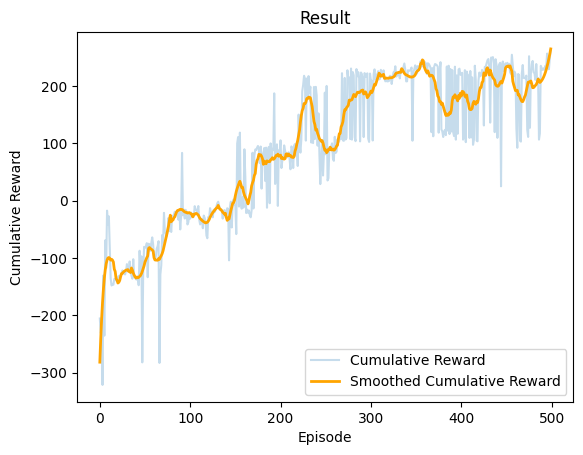

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [25]:
dqn_agent.train(num_episodes=500)

### **Visualizing the DQN agent's policy**
Now that we have trained a DQN agent on the Lunar Lander task, we can visualize its behavior (i.e., policy).

In [26]:
# Choose a random seed.
seed = 42

# Setup new environment.
env = gym.make(env_name, render_mode='rgb_array' if is_running_in_colab else 'human')
env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)

# Visualize the agent.
simulate_agent(env, dqn_agent.policy_net)